In [1]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: Jan 10, 2022
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm

# Set panda's options
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 120)

# Better graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-poster')

In [2]:
sys.path.append('../scripts'); 
from VAE import SentenceVAE
device = "cuda" 

In [3]:
import torch
model_data = torch.load('../models/cuebiq_vae.pt')
params = model_data['params']
model = SentenceVAE(**params).to(device)
model.load_state_dict(model_data['model_state_dict'])
model.eval()

SentenceVAE(
  (embedding): Embedding(8232, 256, padding_idx=0)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (encoder_rnn): GRU(256, 256, batch_first=True)
  (decoder_rnn): GRU(256, 256, batch_first=True)
  (hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (latent2hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2vocab): Linear(in_features=256, out_features=8232, bias=True)
)

In [4]:
from dataloader import MobilitySeqDataset
staysDataset = MobilitySeqDataset(root_dir='/mas/projects/privacy-pres-mobility/data/processed_data/', dataset='cuebiq')

# Exact sequence recreation performance by length of the sequence

The average length of a sequence is 11 locations.

In [5]:
length_wrong = []
accuracy_by_length = {}
for example in tqdm(staysDataset):
    example = example.view(-1,1).to(device)
    logp, mean, logv, z = model(example)
    predicted = logp.max(axis = 2).indices
    if len(example) != len(predicted):
        length_wrong.append(len(example))
    boolean_comapre = example == predicted
    seq_accuracy = boolean_comapre.float().mean().item()
    if len(example) not in accuracy_by_length:
        accuracy_by_length[len(example)] = []
    accuracy_by_length[len(example)].append(seq_accuracy)

  1%|          | 49030/5693662 [00:51<1:45:06, 895.07it/s]

In [ ]:
accuracy_by_length_df = pd.DataFrame([(l,np.mean(acc),np.min(acc), np.quantile(acc,0.05)) for l, acc in accuracy_by_length.items()], columns=['length', 'accuracy', 'min', '5%'])
accuracy_by_length_df.to_csv('../results/cuebiq_vae_accuracy_by_length.csv')

In [106]:
accuracy_by_length_df.sort_values('accuracy')

,length,accuracy,min
518,360,0.999815,0.997222
214,267,0.999850,0.996255
593,291,0.999873,0.996564
268,321,0.999875,0.996885
350,198,0.999877,0.994950
...,...,...,...
378,295,1.000000,1.000000
379,665,1.000000,1.000000
380,593,1.000000,1.000000
352,338,1.000000,1.000000


In [120]:
sum([sum(v) for v in accuracy_by_length.values()]) / sum([len(v) for v in accuracy_by_length.values()])

0.9999997438694455

(0.99, 1.0)

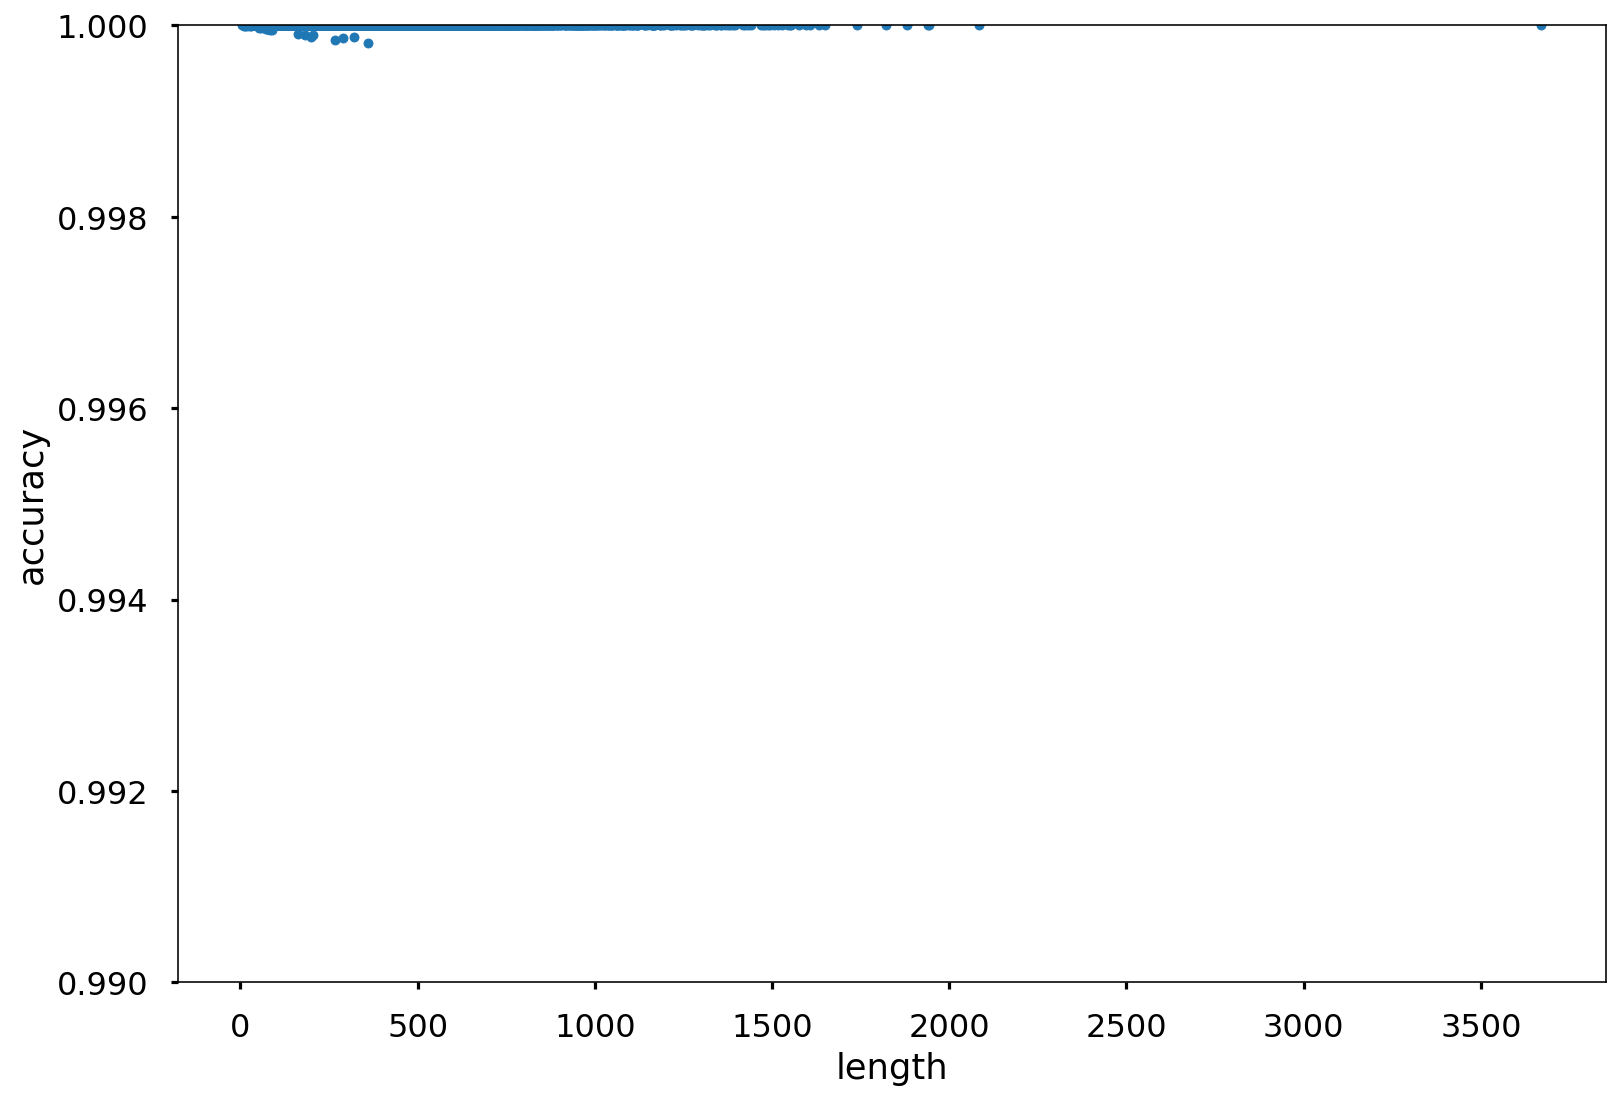

In [114]:
accuracy_by_length_df.plot.scatter(x='length', y='accuracy')
# accuracy_by_length_df.plot.scatter(x='length', y='min')
plt.ylim(0.99,1)